<a href="https://colab.research.google.com/github/faranak-jahedi/CryptoDataset/blob/main/Assignment_1%2C_Q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
! pip install tensorflow_decision_forests
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 34.5 MB/s eta 0:00:00


In [ ]:
print("TensorFlow Decision Forests v" + tfdf.__version__)
print("TensorFlow v" + tf.__version__)

TensorFlow Decision Forests v1.5.0
TensorFlow v2.13.0


**Load the Dataset**

In [ ]:
# Load a dataset into a Pandas DataFrame
train_proteins = pd.read_csv("/content/train_proteins.csv")
train_peptides = pd.read_csv("/content/train_peptides.csv")
train_clinical = pd.read_csv("/content/train_clinical_data.csv")

In [ ]:
print('clinical dataset shape:  ', train_clinical.shape)

clinical dataset shape:   (2615, 8)


In [ ]:
train_clinical.head(5)


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [ ]:
print('proteins dataset shape:  ', train_proteins.shape)

proteins dataset shape:   (232741, 5)


In [ ]:
train_proteins.head(5)

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [ ]:
print('peptides dataset shape:  ', train_peptides.shape)

peptides dataset shape:   (882262, 6)


In [ ]:
train_peptides.head(5)

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0.0,55.0,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0.0,55.0,O00533,GNPEPTFSWTK,102060.0
2,55_0,0.0,55.0,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0.0,55.0,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0.0,55.0,O00533,SMEQNGPGLEYR,30838.7


**Plotting clinical data**

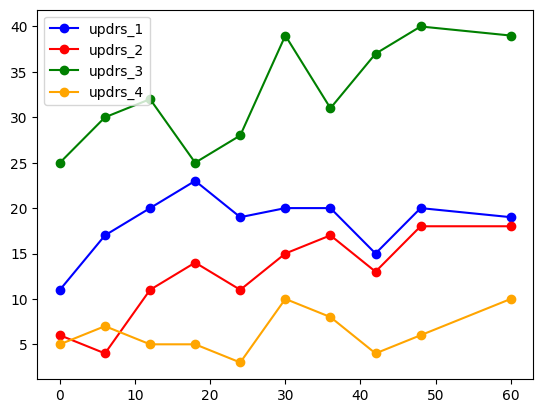

In [ ]:
plot_df = train_clinical[train_clinical["patient_id"]==1517]
fig, ax = plt.subplots(1, 1)

ax.plot(plot_df['visit_month'], plot_df['updrs_1'], marker='o', color="blue", label="updrs_1", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_2'], marker='o', color="red", label="updrs_2", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_3'], marker='o', color="green", label="updrs_3", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_4'], marker='o', color="orange", label="updrs_4", linestyle="-")

ax.legend()
plt.show()

**Plotting protein data**

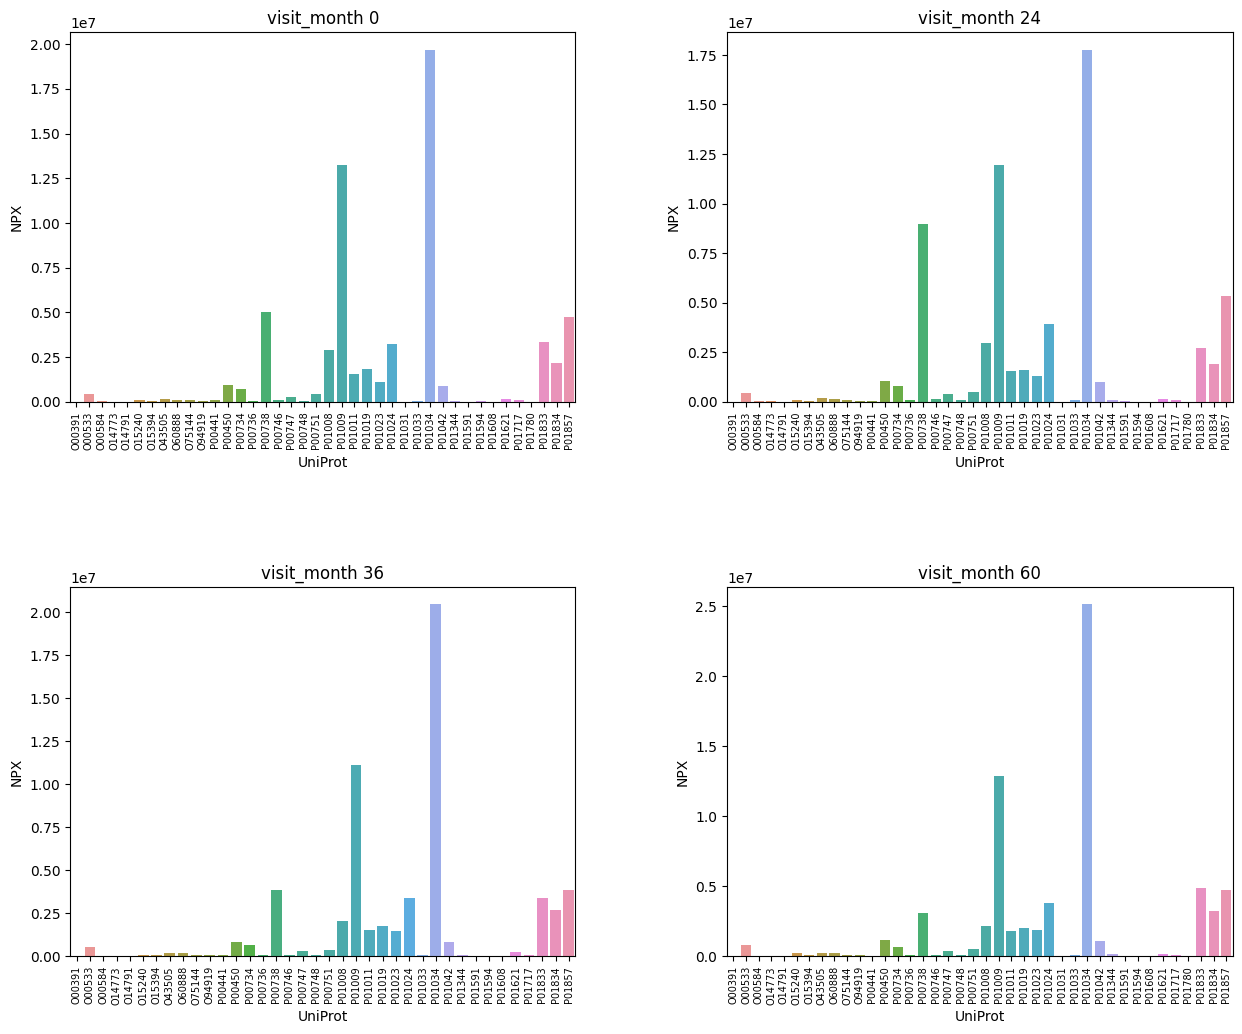

In [ ]:
pro_plot_df = train_proteins[train_proteins["patient_id"]==1517]
protein_list = pro_plot_df['UniProt'].unique()
protein_list = protein_list[:40]
pro_plot_df = pro_plot_df[pro_plot_df['UniProt'].isin(protein_list)]
unique_month = pro_plot_df['visit_month'].unique()
unique_month.sort()
p_len = len(unique_month)

pro_plot_df['visit_month'].unique()
n_rows = math.ceil(p_len/2)
figure, axis = plt.subplots(n_rows, 2, figsize=(15, n_rows*6))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, month in enumerate(unique_month):
    row = i//2
    col = i % 2
    plot_df = pro_plot_df[pro_plot_df['visit_month']==month]
    bp = sns.barplot(ax=axis[row, col], x=plot_df['UniProt'], y=plot_df['NPX'])
    #bp.set(xticklabels=[])
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 7)
    axis[row, col].set_title('visit_month ' + str(month))
plt.show()

**Prepare the dataset**

In [ ]:
# Function to prepare dataset with all the steps mentioned above:
def prepare_dataset(train_proteins, train_peptides):
    # Step 1: Grouping
    df_protein_grouped = train_proteins.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()
    df_peptide_grouped = train_peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()

    # Step 2: Pivoting
    df_protein = df_protein_grouped.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()
    df_peptide = df_peptide_grouped.pivot(index='visit_id',columns = 'Peptide', values = 'PeptideAbundance').rename_axis(columns=None).reset_index()

    # Step 3: Merging
    pro_pep_df = df_protein.merge(df_peptide, on = ['visit_id'], how = 'left')

    return pro_pep_df

In [ ]:
pro_pep_df = prepare_dataset(train_proteins, train_peptides)

**Basic exploration of the prepared dataset**

In [ ]:
pro_pep_df.shape

(1113, 1196)

In [ ]:
pro_pep_df.head(5)

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09


In [ ]:
pro_pep_df.describe()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
count,764.000000,1.112000e+03,1100.000000,1032.000000,1047.000000,942.000000,1113.000000,1050.000000,1110.000000,1079.000000,...,988.000000,888.000000,9.200000e+02,874.000000,9.810000e+02,999.000000,980.000000,994.000000,926.000000,772.000000
mean,11641.264435,5.111649e+05,26505.529157,27305.934884,17688.295406,3004.990691,126151.780054,50773.474638,195599.363694,145382.047368,...,215105.969332,9051.044703,3.924759e+06,68701.359565,6.193345e+05,93035.095093,125784.429441,472214.182998,46996.189730,20718.618354
std,2817.003530,2.357357e+05,10705.152540,8446.187506,7166.325369,1142.159575,72748.393517,21382.028764,79739.704279,58028.089713,...,51318.697969,3115.237399,1.695109e+06,62659.529506,5.102763e+05,30290.815207,38632.359291,129989.389137,13725.791982,10303.953433
min,873.778000,5.971820e+04,591.103000,8945.340000,2811.120000,336.517000,10717.400000,5806.840000,29740.900000,8358.080000,...,12164.300000,258.249000,1.624640e+05,884.260000,7.494660e+03,869.898000,991.452000,11371.200000,6362.490000,868.903000
25%,9736.857500,3.490590e+05,19941.075000,21123.650000,12920.050000,2189.087500,70560.600000,37008.975000,142054.500000,103983.000000,...,185872.750000,6921.115000,2.871838e+06,30986.275000,2.935930e+05,70508.150000,100623.000000,385598.750000,37352.575000,13944.950000
50%,11546.400000,4.834425e+05,26529.700000,26624.000000,17399.600000,2865.460000,116900.000000,50375.800000,185616.000000,136452.000000,...,216530.000000,8633.870000,3.672875e+06,53304.850000,4.791770e+05,89125.600000,123185.000000,463633.500000,45450.100000,20221.100000
75%,13383.025000,6.485572e+05,33222.800000,32459.275000,22077.050000,3593.147500,164947.000000,63446.700000,239731.500000,177451.000000,...,246405.250000,10680.300000,4.711405e+06,87145.350000,7.719060e+05,110556.500000,149682.000000,549718.750000,54895.975000,26653.875000
max,21361.800000,1.806980e+06,66252.400000,65347.900000,49695.600000,9352.640000,538862.000000,137369.000000,766591.000000,427084.000000,...,409939.000000,26256.400000,1.385550e+07,712856.000000,3.984710e+06,221092.000000,264224.000000,948416.000000,107220.000000,70020.800000


In [ ]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

**Select a Model**

In [ ]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

**sMAPE**

In [ ]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

**Training**

In [ ]:
# Create an empty dictionary to store the models trained for each label.
model_dict = {}

# Create an empty dictionary to store the mse score of the models trained for each label.
mse_dict = {}

# Create an empty dictionary to store the sMAPE scores of the models trained for each label.
smape_dict = {}

In [ ]:
FEATURES = [i for i in pro_pep_df.columns if i not in ["visit_id"]]
FEATURES.append("visit_month")

In [ ]:
# List of target labels to loop through and train models
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

# Loop through each label
for label in target:

    # Merge the label 'visit_id', 'patient_id', 'visit_month' and label columns from `train_clinical`
    # data frame to `pro_prep_df` data frame on the `visit_id` column.
    dataset_df = pro_pep_df.merge(train_clinical[['visit_id', 'patient_id', 'visit_month', label]], on = ['visit_id'], how = 'left')

    # Drop null value label rows
    dataset_df = dataset_df.dropna(subset=[label])

    # Make a new copy of the FEATURES list we created previously. Add `label` to it.
    feature_list = FEATURES.copy()
    feature_list.append(label)

    # Split the dataset into train and validation datasets.
    train_df, valid_df = split_dataset(dataset_df[feature_list])
    print("{} examples in training, {} examples in testing.".format(len(train_df), len(valid_df)))

    # There's one more step required before we can train the model.
    # We need to convert the datatset from Pandas format (pd.DataFrame)
    # into TensorFlow Datasets format (tf.data.Dataset).
    # TensorFlow Datasets is a high performance data loading library
    # which is helpful when training neural networks with accelerators like GPUs and TPUs.
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label, task = tfdf.keras.Task.REGRESSION)
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label, task = tfdf.keras.Task.REGRESSION)

    # We will now create the Random Forest Tree Model with default settings.
    # By default the model is set to train for a classification task. Since this is a regression problem,
    # we will specify the type of the task (tfdf.keras.Task.REGRESSION) as a parameter here.
    rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION, verbose=0)
    rf.compile(metrics=["mse"])

    # Train the model.
    rf.fit(x=train_ds)

    # Store the model
    model_dict[label] = rf

    # Evaluate the trained model on the validation dataset and store the
    # mse value in the `mse_dict`.
    inspector = rf.make_inspector()
    inspector.evaluation()
    evaluation = rf.evaluate(x=valid_ds,return_dict=True)
    mse_dict[label] = evaluation["mse"]

    # Use the trained model to make predictions on the validation dataset.
    # Using these predictions, calculate and store the sMAPE value for this model.
    preds = rf.predict(valid_ds)
    smape_dict[label] = smape(valid_df[label].values.tolist(), preds.flatten())

855 examples in training, 213 examples in testing.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 4s 4s/step
862 examples in training, 206 examples in testing.
1/1 [==============================] - 2s 2s/step
826 examples in training, 232 examples in testing.


1/1 [==============================] - 3s 3s/step - loss: 0.0000e+00 - mse: 178.9560


1/1 [==============================] - 2s 2s/step
453 examples in training, 116 examples in testing.
1/1 [==============================] - 2s 2s/step


**Inspect the Mean Squared Error(MSE) scores of the models**

In [ ]:
for name, value in mse_dict.items():
  print(f"label {name}: mse {value:.4f}")

print("\nAverage mse", sum(mse_dict.values())/4)

label updrs_1: mse 26.1757
label updrs_2: mse 21.9604
label updrs_3: mse 178.9560
label updrs_4: mse 9.4609

Average mse 59.13826394081116


**Inspect the sMAPE scores of the models**

In [ ]:
for name, value in smape_dict.items():
  print(f"label {name}: sMAPE {value:.4f}")

print("\nAverage sMAPE", sum(smape_dict.values())/4)

label updrs_1: sMAPE 69.2371
label updrs_2: sMAPE 94.3653
label updrs_3: sMAPE 80.7078
label updrs_4: sMAPE 143.6996

Average sMAPE 97.00244293855889


**Visualize the model**

In [ ]:
# Let us use the model for the label `updrs_1` for this purpose
tfdf.model_plotter.plot_model_in_colab(model_dict['updrs_1'], tree_idx=0, max_depth=3)

**Evaluate the model on the Out of bag (OOB) data and the validation dataset**

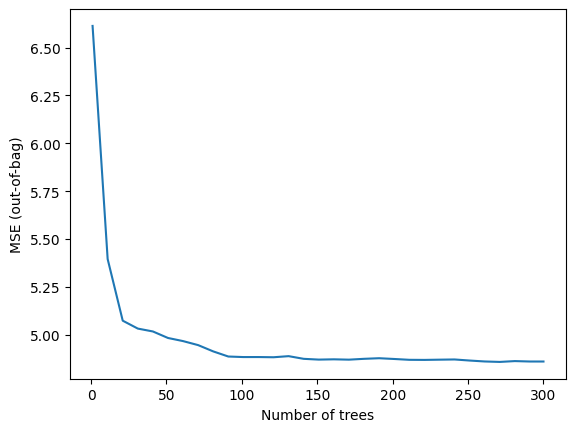

In [ ]:
import matplotlib.pyplot as plt

# Let us use the model for the label `updrs_1` for this purpose
logs = model_dict['updrs_1'].make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("MSE (out-of-bag)")
plt.show()

**Variable importances**

In [ ]:
# Let us use the model for the label `updrs_1` for this purpose
inspector = model_dict['updrs_1'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_AS_ROOT
	 SUM_SCORE
	 NUM_NODES
	 INV_MEAN_MIN_DEPTH


In [ ]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

[("Q06481" (1; #810), 41.0),
 ("FFLC(UniMod_4)QVAGDAK" (1; #230), 27.0),
 ("P04180" (1; #703), 27.0),
 ("P61916" (1; #801), 25.0),
 ("P05060" (1; #712), 16.0),
 ("GEAGAPGEEDIQGPTK" (1; #280), 12.0),
 ("P05067" (1; #713), 11.0),
 ("P23142" (1; #775), 10.0),
 ("P17174" (1; #765), 7.0),
 ("O14773" (1; #633), 6.0),
 ("P13611" (1; #755), 6.0),
 ("AYQGVAAPFPK" (1; #91), 5.0),
 ("DSGEGDFLAEGGGVR" (1; #162), 5.0),
 ("P07602" (1; #729), 5.0),
 ("GNPEPTFSWTK" (1; #301), 4.0),
 ("P09486" (1; #743), 4.0),
 ("P14618" (1; #760), 4.0),
 ("KLYDYC(UniMod_4)DVPQC(UniMod_4)AAPSFDC(UniMod_4)GKPQVEPK" (1; #428), 3.0),
 ("NVVYTC(UniMod_4)NEGYSLIGNPVAR" (1; #627), 3.0),
 ("O15240" (1; #635), 3.0),
 ("P00736" (1; #645), 3.0),
 ("WYFDVTEGK" (1; #1163), 3.0),
 ("DRLDEVKEQVAEVR" (1; #161), 2.0),
 ("EFQLFSSPHGK" (1; #184), 2.0),
 ("GYPGVQAPEDLEWER" (1; #322), 2.0),
 ("ISYGNDALMPSLTETK" (1; #395), 2.0),
 ("KVEQAVETEPEPELR" (1; #447), 2.0),
 ("NIINSDGGPYVC(UniMod_4)R" (1; #599), 2.0),
 ("P02747" (1; #685), 2.0),
 (